## Fine Tuning of VGG16 for Biofuel Material Cassification

In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras as kr
from tensorflow.keras.utils import Sequence
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import itertools

%matplotlib inline

In [2]:
DATASET_ROOT = './dataset/'
TRAIN_FOLDER = 'train'
VALIDATION_FOLDER = 'validation'
TEST_FOLDER = 'test'

#### Image processing & Input preperation

In [50]:
IDG = kr.preprocessing.image.ImageDataGenerator
TR_IDG = IDG(rescale=1)
VA_IDG = IDG(rescale=1)
TE_IDG = IDG(rescale=1)

# Generator for training data set
train_set = TR_IDG.flow_from_directory(
    DATASET_ROOT + TRAIN_FOLDER, 
    target_size=(224,224), 
    batch_size=10
);

# Generator for validation data set
validation_set = VA_IDG.flow_from_directory(
    DATASET_ROOT + VALIDATION_FOLDER, 
    target_size=(224,224), 
    batch_size=10
);

# Generator for test data set
test_set = TE_IDG.flow_from_directory(
    DATASET_ROOT + TEST_FOLDER, 
    target_size=(224,224), 
    batch_size=25
);

Found 2411 images belonging to 2 classes.
Found 917 images belonging to 2 classes.
Found 25 images belonging to 2 classes.


In [7]:
# Tool to display data set and its labels
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
	if type(ims[0]) is np.ndarray:
		ims = np.array(ims).astype(np.uint8)
		if (ims.shape[-1] != 3):
			ims = ims.transpose((0,2,3,1))
	f = plt.figure(figsize=figsize)
	cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
	for i in range(len(ims)):
		sp = f.add_subplot(rows, cols, i+1)
		sp.axis('Off')
		if titles is not None:
			sp.set_title(titles[i], fontsize=16)
		plt.imshow(ims[i], interpolation=None if interp else 'none')

In [ ]:
# next() gets batches of size batch_size
imgs, labels = next(train_set)
# display the batch and its labels
plots(imgs, titles=labels)

#### Fetch & Download VGG16 model

In [4]:
vgg16 = kr.applications.vgg16
vgg16_model = vgg16.VGG16(include_top=True, weights='imagenet')

#### Loading data from a pretrained model (skip if training)
_If running the cell below, skip the build & train phases!_

In [5]:
model = kr.models.load_model("trained_model")
history = []
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                multiple                  138357544 
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1025024   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  2050      
Total params: 139,384,618
Trainable params: 1,027,074
Non-trainable params: 138,357,544
_________________________________________________________________


#### Building and training stages

In [ ]:
# Freeze all the layers
for layer in vgg16_model.layers[:]:
    layer.trainable = False

# Create the model
model = kr.models.Sequential()

# Add the vgg convolutional base model
model.add(vgg16_model)

# easy
Dropout, Flatten, Dense = kr.layers.Dropout, kr.layers.Flatten, kr.layers.Dense

# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

In [ ]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=kr.optimizers.RMSprop(lr=1e-4),
    metrics=['acc']
)

# Train the Model
history = model.fit_generator(
      train_set,
      steps_per_epoch=train_set.samples/train_set.batch_size,
      epochs=20,
      validation_data=validation_set,
      validation_steps=validation_set.samples/validation_set.batch_size,
      verbose=1
)

#### Visualising Training Data

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [59]:
# get predictions for the test set
predictions = model.predict_generator(test_set, steps=1, verbose=1)
# get labels from the test set
_, test_labels = next(test_set)

def ReformatData(y):
    x = np.copy(y[:,0])
    for i in range(len(x)):
        if x[i]>=0.5 or x[i] == True:
            x[i]=1
        else:
            x[i]=0
    x.astype(int)        
    return x
                
cut_predictions = ReformatData(predictions)
cut_labels = ReformatData(test_labels)

print("Cut predictions:",cut_predictions)
print("Cut labels:",cut_labels)
print("Unique labels:",unique_labels(cut_predictions,cut_labels))

1/1 [==============================] - 11s 11s/step
Cut predictions: [1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0.
 1.]
Cut labels: [0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1.
 1.]
Unique labels: [0. 1.]


In [55]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ["non_biofuel","biofuel"]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, abs(i-0.25), format(cm[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.4        0.6       ]
 [0.26666667 0.73333333]]


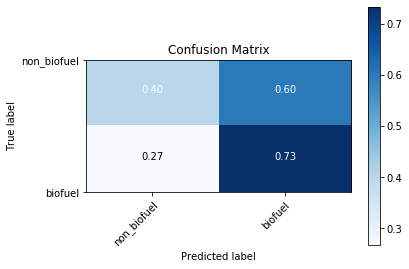

In [60]:
# Plot confusion matrix based on predictions of our test data set
plot_confusion_matrix(cut_labels, cut_predictions, ['biomass', 'non_biomass'], title='Confusion Matrix', normalize=True)

### Cells Below Are for Testing Purposes

In [ ]:
####### DONT RUN - THIS IS FOR TESTING PURPOSES ########

# load the model
test_vgg16 = kr.applications.vgg16
test_model = test_vgg16.VGG16()
# load an image from file
test_image = kr.preprocessing.image.load_img('dataset/train/biomass/cardboard189.jpg', target_size=(224, 224))
# convert the image pixels to a numpy array
test_image = kr.preprocessing.image.img_to_array(test_image)
# reshape data for the model
test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
# prepare the image for the VGG model
test_image = test_vgg16.preprocess_input(test_image)
# predict the probability across all output classes
yhat = test_model.predict(test_image)
# convert the probabilities to class labels
tesT_label = test_vgg16.decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
test_label = test_label[0][0]
# print the classification
print('%s (%.2f%%)' % (test_label[1], test_label[2]*100))